In [0]:
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as A
import cv2
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from albumentations import Compose, Normalize, HorizontalFlip, Cutout, Rotate, RandomCrop, PadIfNeeded
from albumentations.pytorch import ToTensor


In [2]:
import Model as Md
import Misclassified_image as MC
from TrainTestandUtils import TrainTestandUtils as Tt
import cyclic_lr as clr
from Albumentations import AlbumentationTransforms
from GradCAM import GradCAM
from LR_range_test import LR_test
from lr_finder import LRFinder
from Utils import *
import resnet_new as rn

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [0]:

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([                                      
                                      A.PadIfNeeded(min_height=36, min_width=36, border_mode = cv2.BORDER_REFLECT, always_apply=True,),
                                      A.RandomCrop(height=32, width=32, always_apply=True),
                                      A.HorizontalFlip(p = 0.7),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.7) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])


In [5]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=8, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [7]:

model = rn.Net().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

epoch = 1 Lr = 0.001  Loss=1.4029834270477295 Batch_id=97 Accuracy=37.95: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
epoch = 2 Lr = 0.0029  Loss=1.216658592224121 Batch_id=97 Accuracy=43.00: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
epoch = 3 Lr = 0.0048  Loss=1.295762062072754 Batch_id=97 Accuracy=38.86: 100%|██████████| 98/98 [00:23<00:00,  4.14it/s]
epoch = 4 Lr = 0.006699999999999999  Loss=1.6480965614318848 Batch_id=97 Accuracy=30.61: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
epoch = 5 Lr = 0.0086  Loss=1.3709230422973633 Batch_id=97 Accuracy=30.25: 100%|██████████| 98/98 [00:23<00:00,  4.17it/s]
epoch = 6 Lr = 0.0105  Loss=1.6701271533966064 Batch_id=97 Accuracy=21.00: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]
epoch = 7 Lr = 0.012400000000000001  Loss=1.8829865455627441 Batch_id=97 Accuracy=17.89: 100%|██████████| 98/98 [00:23<00:00,  4.16it/s]
epoch = 8 Lr = 0.014300000000000002  Loss=1.7965126037597656 Batch_id=97 Accuracy=18.24: 100%|██████████| 98/98 [0

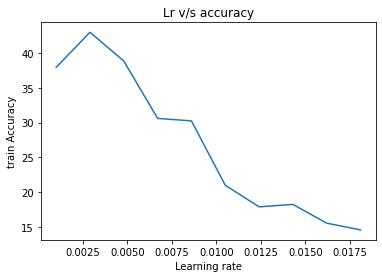

In [8]:
max_lr = 0.02
min_lr = 0.001
epoch = 10
criterion = nn.NLLLoss()
LR_test(max_lr, min_lr,device,epoch,model,criterion,trainloader,momemtum = 0.9,weight_decay=0.05, plot= True )

In [0]:

optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9,weight_decay=0.005 ) 
criterion = nn.NLLLoss()
scheduler = OneCycleLR(optimizer, max_lr = 0.0125, total_steps=None, epochs=24, steps_per_epoch=len(trainloader), pct_start=0.167, anneal_strategy='linear', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=10.0,final_div_factor =1)

In [0]:
new_model = Tt(model=model,
               device=device,
               optimizer=optimizer,
               criterion=criterion,
               scheduler=scheduler,
               trainloader=trainloader,
               testloader=testloader,
               epochs=24,
               input_size=(3,32,32),
               classes=classes)

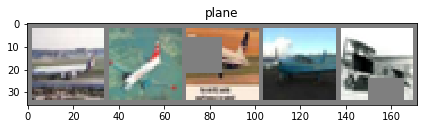

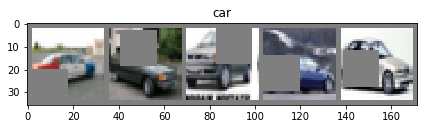

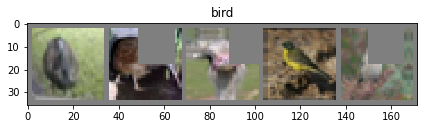

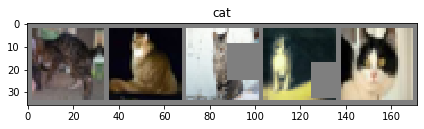

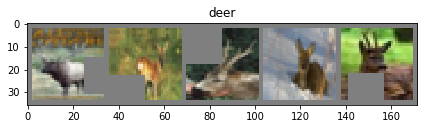

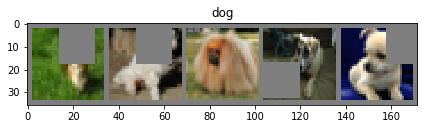

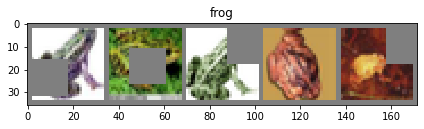

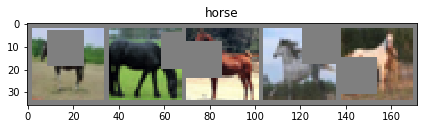

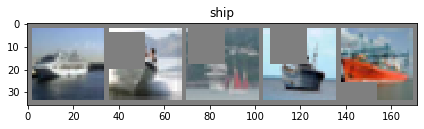

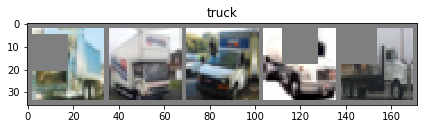

In [11]:
Tt.show_train_data(trainloader, classes)

In [12]:

LR = new_model.runModel()

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH  1


Loss=1.314523696899414 Batch_id=97 Accuracy=41.04: 100%|██████████| 98/98 [00:23<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0025, Accuracy: 5546/10000 (55.46%)

EPOCH  2


Loss=1.2462446689605713 Batch_id=97 Accuracy=58.11: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0022, Accuracy: 6148/10000 (61.48%)

EPOCH  3


Loss=0.978190004825592 Batch_id=97 Accuracy=65.92: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0016, Accuracy: 7220/10000 (72.20%)

EPOCH  4


Loss=0.8312689661979675 Batch_id=97 Accuracy=69.75: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0015, Accuracy: 7539/10000 (75.39%)

EPOCH  5


Loss=0.5924476981163025 Batch_id=97 Accuracy=75.13: 100%|██████████| 98/98 [00:24<00:00,  4.08it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7827/10000 (78.27%)

EPOCH  6


Loss=0.7240630984306335 Batch_id=97 Accuracy=78.05: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0013, Accuracy: 7857/10000 (78.57%)

EPOCH  7


Loss=0.4956401288509369 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8370/10000 (83.70%)

EPOCH  8


Loss=0.5965337157249451 Batch_id=97 Accuracy=82.41: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8309/10000 (83.09%)

EPOCH  9


Loss=0.43123355507850647 Batch_id=97 Accuracy=84.50: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8376/10000 (83.76%)

EPOCH  10


Loss=0.40499940514564514 Batch_id=97 Accuracy=85.82: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0010, Accuracy: 8231/10000 (82.31%)

EPOCH  11


Loss=0.35100236535072327 Batch_id=97 Accuracy=87.08: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0009, Accuracy: 8529/10000 (85.29%)

EPOCH  12


Loss=0.337963730096817 Batch_id=97 Accuracy=88.24: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0008, Accuracy: 8764/10000 (87.64%)

EPOCH  13


Loss=0.3459817171096802 Batch_id=97 Accuracy=89.01: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0008, Accuracy: 8698/10000 (86.98%)

EPOCH  14


Loss=0.3698895573616028 Batch_id=97 Accuracy=89.96: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0007, Accuracy: 8735/10000 (87.35%)

EPOCH  15


Loss=0.2757543921470642 Batch_id=97 Accuracy=90.56: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0007, Accuracy: 8792/10000 (87.92%)

EPOCH  16


Loss=0.2541999816894531 Batch_id=97 Accuracy=91.27: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0007, Accuracy: 8863/10000 (88.63%)

EPOCH  17


Loss=0.21330013871192932 Batch_id=97 Accuracy=91.97: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0007, Accuracy: 8824/10000 (88.24%)

EPOCH  18


Loss=0.24350011348724365 Batch_id=97 Accuracy=92.58: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0006, Accuracy: 8974/10000 (89.74%)

EPOCH  19


Loss=0.2393960952758789 Batch_id=97 Accuracy=93.24: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0007, Accuracy: 8907/10000 (89.07%)

EPOCH  20


Loss=0.21222010254859924 Batch_id=97 Accuracy=93.58: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0006, Accuracy: 8996/10000 (89.96%)

EPOCH  21


Loss=0.15325097739696503 Batch_id=97 Accuracy=94.03: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0006, Accuracy: 9037/10000 (90.37%)

EPOCH  22


Loss=0.16841134428977966 Batch_id=97 Accuracy=94.61: 100%|██████████| 98/98 [00:23<00:00,  4.13it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0005, Accuracy: 9082/10000 (90.82%)

EPOCH  23


Loss=0.1651466190814972 Batch_id=97 Accuracy=95.04: 100%|██████████| 98/98 [00:23<00:00,  4.12it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Test set: Average loss: 0.0006, Accuracy: 9061/10000 (90.61%)

EPOCH  24


Loss=0.18225634098052979 Batch_id=97 Accuracy=95.58: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]


Test set: Average loss: 0.0005, Accuracy: 9109/10000 (91.09%)



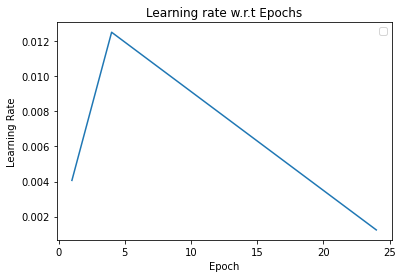

In [13]:
import numpy as np
curves = [{"x":np.arange(1,25), "y": LR, "label": "","xlabel": "Epoch", "ylabel":"Learning Rate"}]
Tt.plot_curve(curves,"Learning rate w.r.t Epochs",Figsize = (6,4))

In [14]:
new_model.total_accuracy()

Accuracy of the network on the 10000 test images: 91 %


In [16]:
new_model.classwise_acc()


Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 58 %
Accuracy of  deer : 100 %
Accuracy of   dog : 66 %
Accuracy of  frog : 90 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %



Length of train acc is 24
Length of test acc is 24


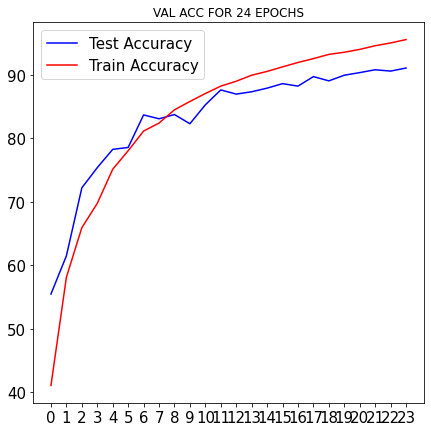

In [17]:
new_model.plot_train_test_acc()